In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from pydmd import DMDc
from pydmd.plotter import plot_eigs
import os
import re
from flowtorch.data import FOAMDataloader, mask_box
import torch as pt

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [2]:
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f1.5"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)
u_inlet = 1.0
p = np.array(loader.load_snapshot("p", times[1:]))
#normaling p
p = p[:, 399:]/u_inlet**2

u_x = np.array(loader.load_snapshot("U", times[1:]))[:,0,:]

#normalizing u_x
u_x = u_x[:, 399:]/u_inlet

u_y = np.array(loader.load_snapshot("U", times[1:]))[:,1,:]
#normalizing u_x
u_y = u_y[:, 399:]/u_inlet

print(p.shape, u_x.shape, u_y.shape)

state_matrix = np.vstack((p, u_x, u_y))

times_num = np.array(list(map(float, times)))
times_num = times_num[400:]
#p = p[:, 399:]
A, f = 0.5, 1.5
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))


(21250,) (21250,)
(21250, 401) (21250, 401) (21250, 401)


In [3]:
#Splitting training and test data
train_test_ratio = 0.75
data = p
index = round(train_test_ratio*data.shape[1])
train_data = data[:,:index]
test_data = data[:,index:]
train_u = u[:,:index-1]
test_u = u[:,index-1:]
s = {"snapshots": train_data, "u": train_u, "test_snapshot": test_data, "test_u": test_u }
print(s["snapshots"].shape)
print(s["u"].shape)
print(s["test_snapshot"].shape)
print(s["test_u"].shape)


(21250, 301)
(1, 300)
(21250, 100)
(1, 100)


In [4]:
dmdc = DMDc(svd_rank= 44)
dmdc.fit(s["snapshots"], s["u"])

/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 327007.84375. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [6]:
#reconstructing the data
reconstructed_data = dmdc.reconstructed_data()
reconstructed_data.shape

(21250, 301)

NameError: name 'reconstructed_data' is not defined

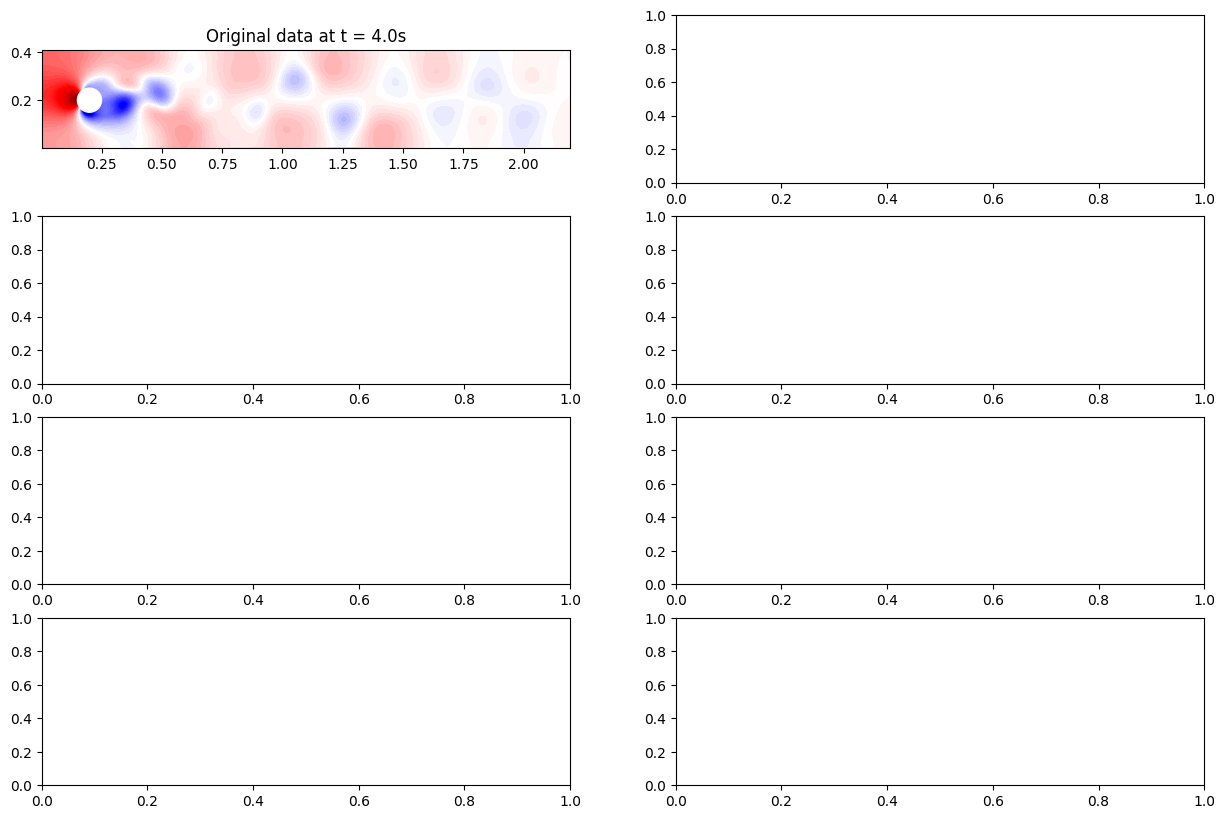

In [5]:
# Visualizing reconstructed data
vmin, vmax = s["snapshots"].min(), s["snapshots"].max()
levels = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize = (15, 10), nrows = 4, ncols = 2)
plot_times = [0, 150, 270, 300]
for i,time in enumerate(plot_times):
    ax[i,0].tricontourf(x, y, s["snapshots"][:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Original data at t = {}s".format(time*0.01+4))

    ax[i,1].tricontourf(x, y, reconstructed_data[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Reconstructed data at t = {}s".format(time*0.01+4))


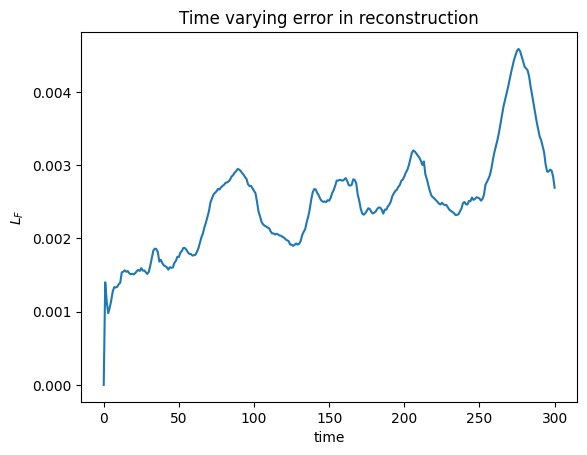

In [8]:
# Evaluating error in reconstruction
error = np.linalg.norm(s["snapshots"]-reconstructed_data, axis = 0)/np.linalg.norm(s["snapshots"], axis = 0)
plt.xlabel("time")
plt.ylabel(r"$L_{F}$")
plt.title("Time varying error in reconstruction")
plt.plot(error)
plt.show()

In [6]:
# Predicting future flow evolution

A_tilde = dmdc._Atilde._Atilde
print(A_tilde.shape)
B_tilde = dmdc.basis.T.dot(dmdc.B)
print(B_tilde.shape)



(44, 44)
(44, 1)


In [7]:
x_curr = dmdc.basis.T.dot(s["snapshots"][:,-1]) #need to use original or recontructed data to initialize?
x_curr = x_curr.reshape(len(x_curr),1)
print(x_curr.shape)
predicted_flow_tilde = np.empty((len(x_curr), 0))
for i in range(s["test_snapshot"].shape[1]):
    x_curr = A_tilde.dot(x_curr) + B_tilde.dot(s["test_u"][0,i])
    predicted_flow_tilde = np.hstack((predicted_flow_tilde,x_curr))
print(predicted_flow_tilde.shape)

(44, 1)
(44, 100)


In [8]:
# Projecting predicted flow to full rank
predicted_flow = dmdc.basis.dot(predicted_flow_tilde)
print(predicted_flow.shape)

(21250, 100)


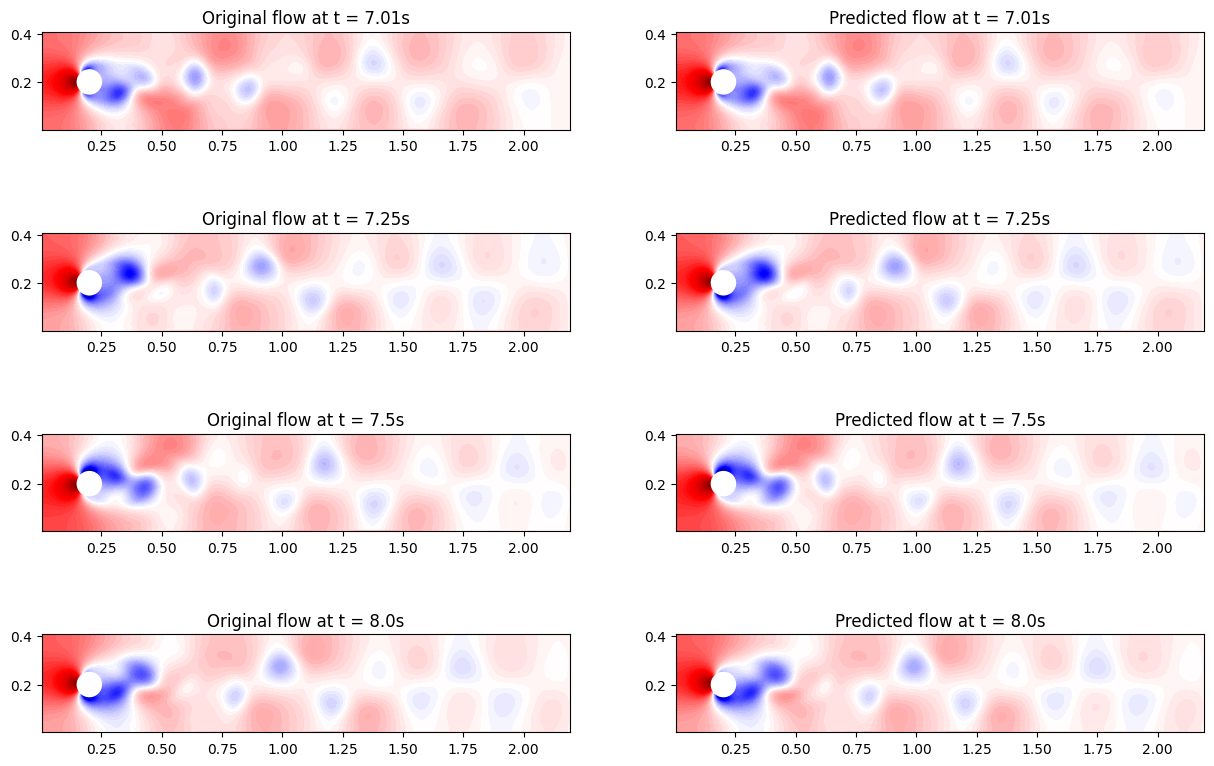

In [9]:
# Visualizing predicted flow to original flow
vmin, vmax = s["test_snapshot"].min(), s["test_snapshot"].max()
levels = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize = (15, 10), nrows = 4, ncols = 2)
plot_times = [0, 24, 49, 99]
for i,time in enumerate(plot_times):
    ax[i,0].tricontourf(x, y, s["test_snapshot"][:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Original flow at t = {}s".format(time*0.01+7.01))

    ax[i,1].tricontourf(x, y, predicted_flow[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Predicted flow at t = {}s".format(time*0.01+7.01))

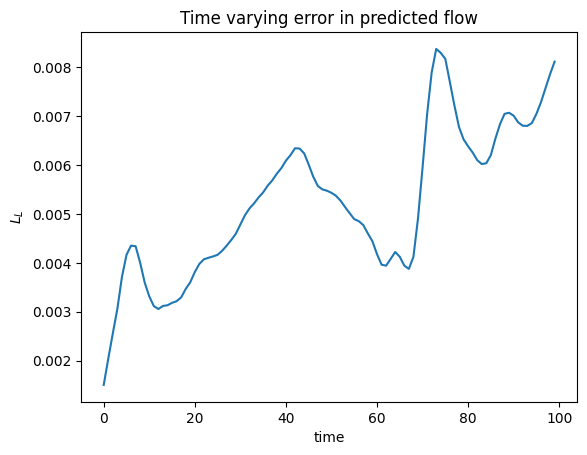

In [10]:
# Evaluating error in predicted flow
error_predicted = np.linalg.norm(s["test_snapshot"]-predicted_flow, axis = 0)/np.linalg.norm(s["test_snapshot"], axis = 0)
plt.xlabel("time")
plt.ylabel(r"$L_{L}$")
plt.title("Time varying error in predicted flow")
plt.plot(error_predicted)
plt.show()

In [11]:
# Predicting the flow for unforced case using initial value from unforced case using reduced order matrices
# The initial state for forced and unforced case will be different at t = 4s
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f2.1"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times

p_forced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_forced.shape)

x_curr = np.array(loader.load_snapshot("p", times[1:]))[:,398]
x_curr = dmdc.basis.T.dot(x_curr)
x_curr = x_curr.reshape(len(x_curr), 1)
time_forced = np.array(range(399, 800))/100
#print("time", time_unforced.shape)
A, f = 0.5, 2.1
u_forced = np.atleast_2d(A*np.sin(2*np.pi*f*time_forced))
print(u_forced.shape)
predicted_flow_forced_tilde = np.empty((len(x_curr), 0))
for i in range(p_forced.shape[1]):
    x_curr = A_tilde.dot(x_curr) + B_tilde.dot(u_forced[0,i])
    predicted_flow_forced_tilde = np.hstack((predicted_flow_forced_tilde,x_curr))
print(predicted_flow_forced_tilde.shape)

(21250, 401)
(1, 401)
(44, 401)


In [12]:
# Projecting predicted flow to full rank
predicted_flow_forced = dmdc.basis.dot(predicted_flow_forced_tilde)
print(predicted_flow_forced.shape)

(21250, 401)


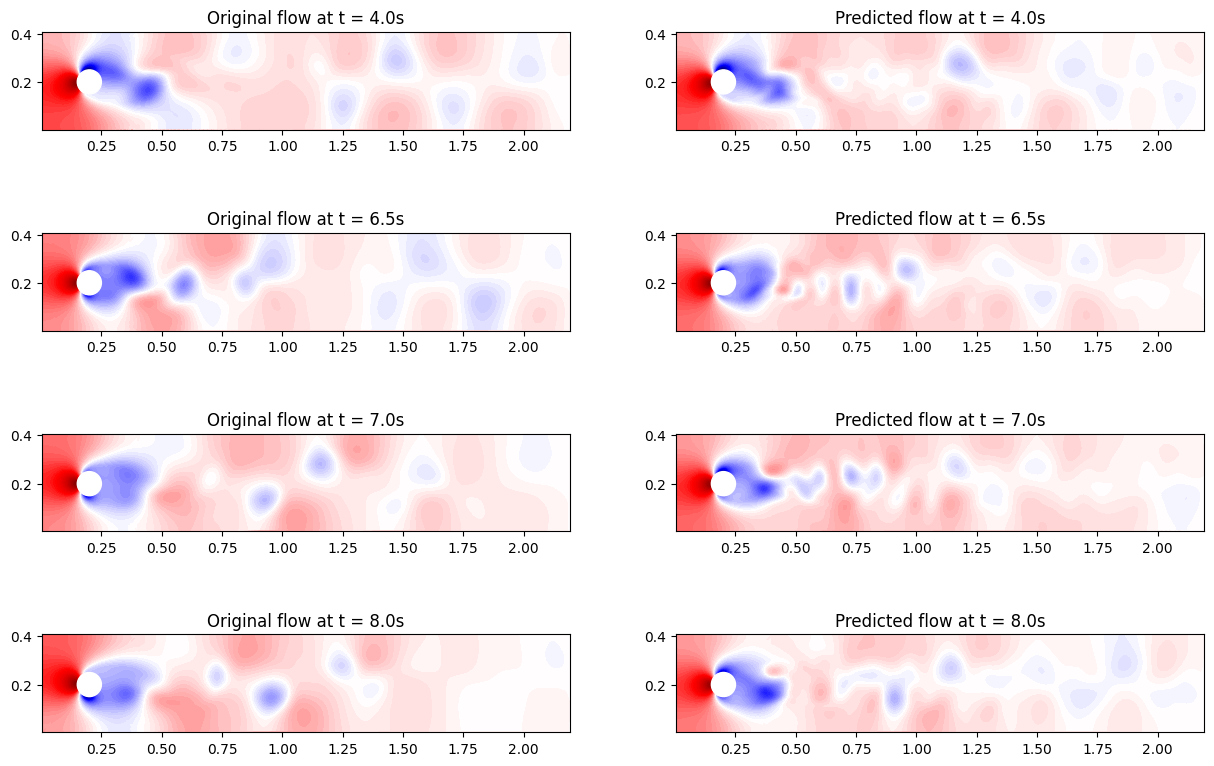

In [13]:
# Visualizing predicted flow for unforced case to original flow
vmin, vmax = p_forced.min(), p_forced.max()
levels = np.linspace(vmin, vmax, 100)
fig, ax = plt.subplots(figsize = (15, 10), nrows = 4, ncols = 2)
plot_times = [0, 250, 300, 400]
for i,time in enumerate(plot_times):
    ax[i,0].tricontourf(x, y, p_forced[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Original flow at t = {}s".format(time*0.01+4))

    ax[i,1].tricontourf(x, y, predicted_flow_forced[:, time], levels=levels, vmin=vmin, vmax=vmax, cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Predicted flow at t = {}s".format(time*0.01+4))

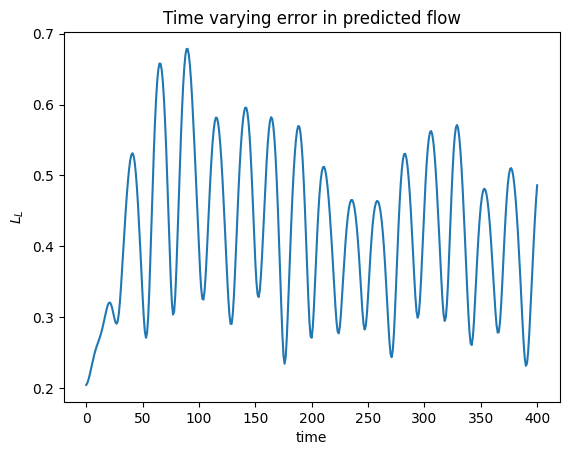

In [14]:
# Evaluating error in predicted flow
error_predicted = np.linalg.norm(p_forced-predicted_flow_forced, axis = 0)/np.linalg.norm(p_forced, axis = 0)
plt.xlabel("time")
plt.ylabel(r"$L_{L}$")
plt.title("Time varying error in predicted flow")
plt.plot(error_predicted)
plt.show()

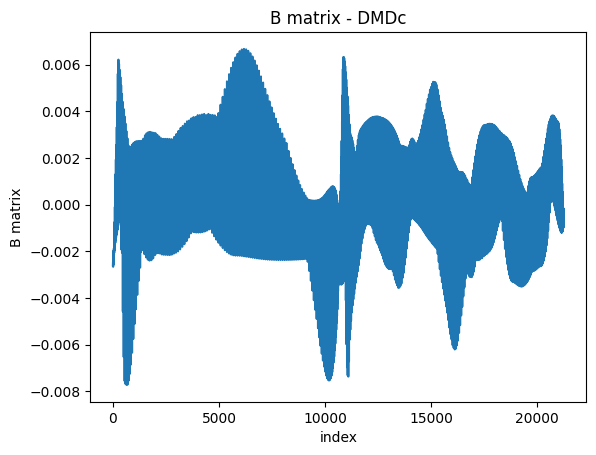

In [15]:
# plot B matrix from DMDc
plt.plot(dmdc.B)
plt.title("B matrix - DMDc")
plt.xlabel("index")
plt.ylabel("B matrix")
plt.show()

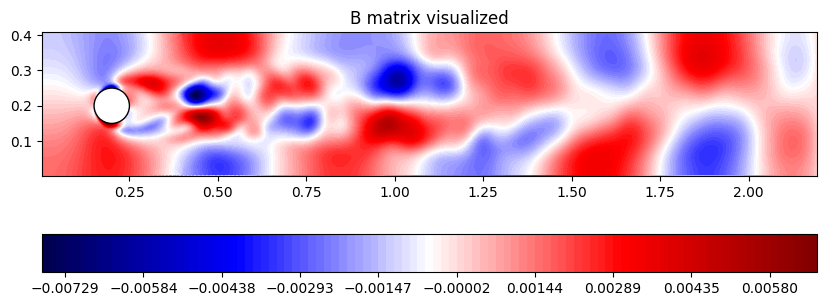

In [19]:
# Visualizing matrix B as field

fig, ax = plt.subplots(figsize = (10, 5))
m = ax.tricontourf(x, y, dmdc.B.flatten(), levels = np.linspace(dmdc.B.min(), dmdc.B.max(), 100), vmin=dmdc.B.min(), vmax=dmdc.B.max(), cmap="seismic")
ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
ax.set_aspect("equal")
ax.set_title("B matrix visualized")
fig.colorbar(m, orientation = "horizontal")
plt.show()